In [43]:
# Import libraries

import pandas as pd
from sklearn.cluster import KMeans
from sklearn.impute import SimpleImputer
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
import numpy as np
from sklearn.metrics import silhouette_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.utils import to_categorical

In [44]:
# !unzip players2023.zip
# Link for dataset: https://www.kaggle.com/datasets/amirhosseinmirzaie/nba-players-stats2023-season

# Note that the dataset I am using is not the exact same - I have modified some of the position values
# to match that of outside sites

# Exploratory Analysis

In [45]:
# Load the dataset

file_path = "2023_nba_player_stats.csv"
df = pd.read_csv(file_path)
display(df)

,PName,POS,Team,Age,GP,W,L,Min,PTS,FGM,...,REB,AST,TOV,STL,BLK,PF,FP,DD2,TD3,+/-
0,Jayson Tatum,SF,BOS,25,74,52,22,2732.2,2225,727,...,649,342,213,78,51,160,3691,31,1,470
1,Joel Embiid,C,PHI,29,66,43,23,2284.1,2183,728,...,670,274,226,66,112,205,3706,39,1,424
2,Luka Doncic,PG,DAL,24,66,33,33,2390.5,2138,719,...,569,529,236,90,33,166,3747,36,10,128
3,Shai Gilgeous-Alexander,PG,OKC,24,68,33,35,2416.0,2135,704,...,329,371,192,112,65,192,3425,3,0,149
4,Giannis Antetokounmpo,PF,MIL,28,63,47,16,2023.6,1959,707,...,742,359,246,52,51,197,3451,46,6,341
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
534,Alondes Williams,SG,BKN,23,1,1,0,5.3,0,0,...,1,0,2,0,0,1,-1,0,0,-5
535,Deonte Burton,SF,SAC,29,2,1,1,6.5,0,0,...,0,0,0,0,0,0,0,0,0,5
536,Frank Jackson,PG,UTA,24,1,0,1,5.0,0,0,...,2,1,0,0,0,0,4,0,0,-2
537,Michael Foster Jr.,PF,PHI,20,1,1,0,1.0,0,0,...,0,0,0,0,0,0,0,0,0,-2


## Context:
This dataset captures attributes and performance statistics for NBA players during the 2022-2023 season. Key descriptive attributes include player names (PName), positions (POS), team they were on at the end of the season (Team), and ages (Age). Performance statistics cover both aggregate season totals and efficiency metrics, such as points scored (PTS), field goals made and attempted (FGM, FGA), three-point shooting statistics (3PM, 3PA, 3P%), free throws (FTM, FTA, FT%), and advanced stats like player impact (+/−).

Rebounding, assists, turnovers, and defensive contributions are represented through stats like offensive rebounds (OREB), defensive rebounds (DREB), assists (AST), steals (STL), blocks (BLK), and turnovers (TOV). Metrics such as double-doubles (achieving double digits in two statistical categories, DD2), triple-doubles (achieving double digits in three statistical categories, TD3), and fantasy points (FP), a calculated performance metric used for fantasy leagues, provide further insight to player achievements.

For my project, I will end up using features engineered from PTS, REB, AST, TOV, STL, BLK, FTA, FT%, FGA, FG%, 3PA, 3P%, and FP. However, the final selection of these features was determined after experimenting with a broader range of features. This exploratory process was essential, as the other features played a significant role in shaping my understanding of the data and informed my decisions, even though they were ultimately not included in the final result.

## Feature engineering

### "Per game" statistics

In [46]:
# Engineering "per game" statistics using players' aggregate statistics
# across all games divided by number of games played

df['PPG'] = df['PTS'] / df['GP']  # Points per game
df['APG'] = df['AST'] / df['GP']  # Assists per game
df['RPG'] = df['REB'] / df['GP']  # Rebounds per game
df['ORPG'] = df['OREB'] / df['GP']  # Rebounds per game
df['DRPG'] = df['DREB'] / df['GP']  # Rebounds per game
df['TPG'] = df['TOV'] / df['GP']  # Points per game
df['SPG'] = df['STL'] / df['GP']  # Assists per game
df['BPG'] = df['BLK'] / df['GP']  # Blocks per game
df['Min'] = df['Min'] / df['GP']  # Minutes per game
df['PFG'] = df['PF'] / df['GP']   # Personal fouls per game
df['FPG'] = df['FP'] / df['GP']   # Fantasy points per game
df['+/-G'] = df['+/-'] / df['GP'] # +/- per game
df['3PAG'] = df['3PA'] / df['GP'] # 3 point attempts per game
df['FGAG'] = df['FGA'] / df['GP'] # Field goal attempts per game
df['FTAG'] = df['FTA'] / df['GP'] # Free throw attempts per game

### Position simplification

In [47]:
# Due to modern flexibility and ambiguity regarding player position, along with
# dataset's "vague" labeling of certain PG/SG as G, combine PG and SG into G, and SF and PF into F

df['POS_grouped'] = df['POS'].replace({
    'PG': 'G',
    'SG': 'G',
    'SF': 'F',
    'PF': 'F'
})

df['POS_grouped'] = df['POS']

### Win percentage

In [48]:
# Create win percentage column to better understand team performance,
# especially for those unfamiliar with NBA season length

df['W%'] = df['W'] / (df['W'] + df['L'])

In [49]:
print(df.columns)

Index(['PName', 'POS', 'Team', 'Age', 'GP', 'W', 'L', 'Min', 'PTS', 'FGM',
       'FGA', 'FG%', '3PM', '3PA', '3P%', 'FTM', 'FTA', 'FT%', 'OREB', 'DREB',
       'REB', 'AST', 'TOV', 'STL', 'BLK', 'PF', 'FP', 'DD2', 'TD3', '+/-',
       'PPG', 'APG', 'RPG', 'ORPG', 'DRPG', 'TPG', 'SPG', 'BPG', 'PFG', 'FPG',
       '+/-G', '3PAG', 'FGAG', 'FTAG', 'POS_grouped', 'W%'],
      dtype='object')


## Summary statistics

### General summary statistics

In [50]:
league_summary = df.describe()
display(league_summary)

,Age,GP,W,L,Min,PTS,FGM,FGA,FG%,3PM,...,TPG,SPG,BPG,PFG,FPG,+/-G,3PAG,FGAG,FTAG,W%
count,539.000000,539.000000,539.000000,539.000000,539.000000,539.000000,539.000000,539.000000,539.000000,539.000000,...,539.000000,539.000000,539.000000,539.000000,539.000000,539.000000,539.000000,539.000000,539.000000,539.000000
mean,25.970315,48.040816,24.018553,24.022263,19.796567,523.426716,191.576994,403.005566,46.325232,56.324675,...,1.103899,0.607471,0.380069,1.688659,18.331807,-0.374793,2.782890,7.103247,1.855938,0.486446
std,4.315513,24.650686,14.496366,13.445866,9.541295,498.084360,178.351286,369.595909,10.967271,60.916821,...,0.826903,0.398309,0.383794,0.791648,11.649938,3.165576,2.243816,4.956602,1.880296,0.170035
min,19.000000,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,-1.000000,-29.000000,0.000000,0.000000,0.000000,0.000000
25%,23.000000,30.500000,12.000000,14.000000,12.452484,120.500000,45.500000,93.500000,41.650000,5.000000,...,0.518544,0.321092,0.138889,1.175845,9.630952,-1.917317,1.000000,3.376025,0.629123,0.408249
50%,25.000000,54.000000,25.000000,25.000000,19.185185,374.000000,138.000000,300.000000,45.500000,36.000000,...,0.880000,0.557143,0.272727,1.648649,15.283784,-0.246154,2.365385,5.772727,1.225000,0.500000
75%,29.000000,68.000000,36.000000,34.000000,28.346682,769.500000,283.500000,598.500000,50.600000,92.000000,...,1.500000,0.833333,0.496835,2.203448,25.133929,1.354232,4.097619,9.450634,2.407077,0.585786
max,42.000000,83.000000,57.000000,60.000000,40.800000,2225.000000,728.000000,1559.000000,100.000000,301.000000,...,4.109589,3.000000,3.000000,5.000000,56.772727,9.275362,11.410714,22.163636,12.253968,1.000000


### Summary statistics for each position

In [51]:
numeric_df = df.select_dtypes(include=['number'])

agg_dict = {col: ['mean', 'median', 'std'] for col in numeric_df.columns if col != 'POS_grouped'}
position_summary = df.groupby('POS_grouped')[numeric_df.columns].agg(agg_dict).reset_index()

display(position_summary)

POS_grouped        Age                          GP                    \
                    mean median       std       mean median        std   
0           C  26.437500   25.0  4.136420  46.787500   49.5  23.991926   
1          PF  26.085714   25.0  4.802071  50.561905   56.0  23.896783   
2          PG  26.525253   25.0  4.502479  47.989899   56.0  23.676603   
3          SF  26.274336   26.0  4.268338  49.230088   56.0  24.979280   
4          SG  24.992958   24.0  3.810207  45.971831   52.0  26.048766   

           W                    ...      3PAG      FGAG                      \
        mean median        std  ...       std      mean    median       std   
0  22.850000   23.5  13.951181  ...  1.493110  5.736711  4.541145  4.044107   
1  25.400000   24.0  14.245512  ...  1.681844  6.520436  5.222222  4.392302   
2  24.232323   27.0  14.361107  ...  2.428509  8.480997  7.200000  5.575055   
3  24.548673   25.0  14.425914  ...  2.030984  7.122392  5.750000  4.937365   
4  23.084507   23.5  15.202413  ...  2.394115  7.328301  6.257407  5.165790   

       FTAG                            W%                      
       mean    median       std      mean    median       std  
0  2.062246  1.814536  1.788566  0.472429  0.486278  0.156344  
1  1.873642  1.235294  2.055730  0.493705  0.518987  0.176955  
2  2.146606  1.311475  2.241946  0.471788  0.500000  0.160913  
3  1.722796  1.000000  1.791585  0.484615  0.500000  0.164540  
4  1.629919  1.149681  1.545404  0.500651  0.500000  0.183073  

[5 rows x 127 columns]

__Analysis:__    
Based on this table, some statistics that differ from position to position include:
- Points: Guards score the most, aligning with their role as primary scorers in the modern "small ball" era. They are often relied upon for perimeter shooting and driving to the basket.
- Assists: Guards lead in assists due to their playmaking responsibilities as offensive facilitators, orchestrating the team's offense and creating scoring opportunities.
- Rebounds: Centers dominate in rebounding, leveraging their height and positioning near the basket to secure boards. This advantage is critical for maintaining possession and initiating plays.
- Turnovers: Guards and centers experience the most turnovers. Guards handle the ball frequently, increasing turnover risk, while centers often face double-teams and struggle with ball handling under pressure.
- Blocks: Centers excel in blocking shots, using their height and reach to protect the rim and disrupt opponents' scoring attempts.
- Personal fouls: Centers commit the most fouls as they anchor the defense and often contest shots near the rim, leading to more fouls drawn in the paint.
- Fantasy points: Centers generate the most fantasy points due to their strong contributions in rebounds, blocks, and efficiency metrics, which is valued for the fantasy point metric.
- Durability: Forwards are the most durable, likely due to a balance between the physical demands of guards and the injury risks associated with taller players like centers.



### Summary statistics for each team

In [52]:
# Calculate league-wide means for statistics
stats = ['PPG', 'RPG', 'APG', 'FPG', 'GP', '+/-G']
league_means = df[stats].mean()

# Calculate team summary statistics
team_summary = (
    df.groupby('Team').agg({
        'PPG': 'mean',
        'RPG': 'mean',
        'APG': 'mean',
        'FPG': 'mean',
        'GP': 'mean',
        '+/-G': 'mean',
    }).reset_index()
)

# Add columns for differences from league means
for stat in stats:
    team_summary[f'{stat}_Diff_Mean'] = team_summary[stat] - league_means[stat]

# Get wins per team
team_wins = df.drop_duplicates(subset='Team')[['Team', 'W%', 'W']]

# Merge team wins with team summaries and sort based on wins
team_summary = pd.merge(team_summary, team_wins, on="Team")
team_summary = team_summary[['W', 'W%', 'Team', 'PPG', 'RPG', 'APG', 'FPG', 'GP', '+/-G'] + [f'{stat}_Diff_Mean' for stat in stats]]
team_summary = team_summary.sort_values(by='W', ascending=False)

display(team_summary)

,W,W%,Team,PPG,RPG,APG,FPG,GP,+/-G,PPG_Diff_Mean,RPG_Diff_Mean,APG_Diff_Mean,FPG_Diff_Mean,GP_Diff_Mean,+/-G_Diff_Mean
2,52,0.702703,BOS,8.593508,3.752773,1.985125,17.933104,49.777778,2.149888,-0.525314,0.211882,-0.082934,-0.398702,1.736961,2.524680
7,48,0.695652,DEN,9.710961,3.830476,2.332234,19.622172,57.125000,1.098628,0.592140,0.289585,0.264175,1.290366,9.084184,1.473421
16,47,0.746032,MIL,9.552347,3.900058,2.157762,18.828970,47.500000,0.835964,0.433526,0.359168,0.089702,0.497164,-0.540816,1.210757
25,44,0.602740,SAC,7.072480,2.699509,1.625197,13.944528,48.100000,0.167638,-2.046341,-0.841381,-0.442862,-4.387279,0.059184,0.542431
5,44,0.647059,CLE,8.609938,3.034770,1.926305,17.226368,46.352941,1.752685,-0.508883,-0.506121,-0.141754,-1.105439,-1.687875,2.127478
19,44,0.571429,NYK,9.753553,4.099995,2.070532,19.431846,56.250000,0.430021,0.634732,0.559104,0.002473,1.100039,8.209184,0.804814
9,44,0.536585,GSW,9.619638,3.599576,2.442990,19.152503,49.529412,0.911661,0.500817,0.058685,0.374931,0.820697,1.488595,1.286454
22,43,0.651515,PHI,10.409473,3.606381,2.223157,19.852327,51.166667,1.596659,1.290652,0.065490,0.155098,1.520520,3.125850,1.971452
1,42,0.506024,BKN,8.481636,3.584282,2.180541,18.101007,47.400000,-1.176638,-0.637186,0.043391,0.112482,-0.230800,-0.640816,-0.801845
15,40,0.533333,MIA,9.664844,3.924726,2.018196,19.167166,45.588235,-0.204067,0.546023,0.383835,-0.049863,0.835359,-2.452581,0.170726


In [53]:
# Calculate league-wide medians for the statistics
stats = ['PPG', 'RPG', 'APG', 'FPG', 'GP', '+/-G']
league_medians = df[stats].median()

# Calculate team summary statistics
team_summary = (
    df.groupby('Team').agg({
        'PPG': 'median',
        'RPG': 'median',
        'APG': 'median',
        'FPG': 'median',
        'GP': 'median',
        '+/-G': 'median',
    }).reset_index()
)

# Add columns for differences from league medians
for stat in stats:
    team_summary[f'{stat}_Diff_Median'] = team_summary[stat] - league_medians[stat]

# Get wins per team
team_wins = df.drop_duplicates(subset='Team')[['Team', 'W%', 'W']]

# Merge team wins with team summaries and sort based on wins
team_summary = pd.merge(team_summary, team_wins, on="Team")
team_summary = team_summary[['W', 'W%', 'Team', 'PPG', 'RPG', 'APG', 'FPG', 'GP', '+/-G'] + [f'{stat}_Diff_Median' for stat in stats]]
team_summary = team_summary.sort_values(by='W', ascending=False)

display(team_summary)

,W,W%,Team,PPG,RPG,APG,FPG,GP,+/-G,PPG_Diff_Median,RPG_Diff_Median,APG_Diff_Median,FPG_Diff_Median,GP_Diff_Median,+/-G_Diff_Median
2,52,0.702703,BOS,6.239683,3.176685,1.380952,12.461210,62.0,2.662006,-0.793104,0.143352,0.010582,-2.822573,8.0,2.908160
7,48,0.695652,DEN,8.808565,2.670308,1.282738,16.295814,61.0,-1.050000,1.775778,-0.363025,-0.087632,1.012031,7.0,-0.803846
16,47,0.746032,MIL,7.017081,3.037138,1.500000,16.405797,52.0,0.510317,-0.015706,0.003804,0.129630,1.122013,-2.0,0.756471
25,44,0.602740,SAC,3.979437,2.185938,0.765390,8.965909,53.0,0.732572,-3.053350,-0.847396,-0.604980,-6.317875,-1.0,0.978726
5,44,0.647059,CLE,5.290323,2.285714,1.144737,13.000000,48.0,1.657895,-1.742464,-0.747619,-0.225634,-2.283784,-6.0,1.904049
19,44,0.571429,NYK,7.395396,3.384735,1.518519,15.686476,65.5,0.839436,0.362609,0.351402,0.148148,0.402692,11.5,1.085589
9,44,0.536585,GSW,6.866667,3.447761,2.297297,14.644444,57.0,1.500000,-0.166120,0.414428,0.926927,-0.639339,3.0,1.746154
22,43,0.651515,PHI,8.274123,3.661709,1.306090,14.966599,59.0,1.143107,1.241336,0.628375,-0.064281,-0.317185,5.0,1.389261
1,42,0.506024,BKN,7.363335,3.061802,1.433333,14.266947,50.5,-0.120951,0.330548,0.028469,0.062963,-1.016837,-3.5,0.125203
15,40,0.533333,MIA,8.209677,3.481481,1.647887,17.279412,54.0,-0.126761,1.176891,0.448148,0.277517,1.995628,0.0,0.119393


__Analysis:__ For the most part, the teams that win more have more total points, rebounds, assists, and +/- across all their players, exemplified by the position differentials across the top of the datasets, and the negative differential across the bottom. It also reveals how most teams are built in terms of star power - one or two extremely high level players skew the mean to be greater than the median. Some less successful teams have similar means and medians, representing the even distribution of production across the team, and a lack of a star player(s). It also reveals the identity of certain teams - Boston (BOS) sees their success from a more balanced team, and maintains a higher average +/- despite having lower statistics in other areas, while a team like Denver (DEN) or Milwaukee (MIL) sees their success from extremely high production by one MVP-level player, who plays for most of the game, giving them higher average statistics, but a lower average +/- due to the dropoff in production when they step off the court.

## Graphs and visualizations

### Number of games played

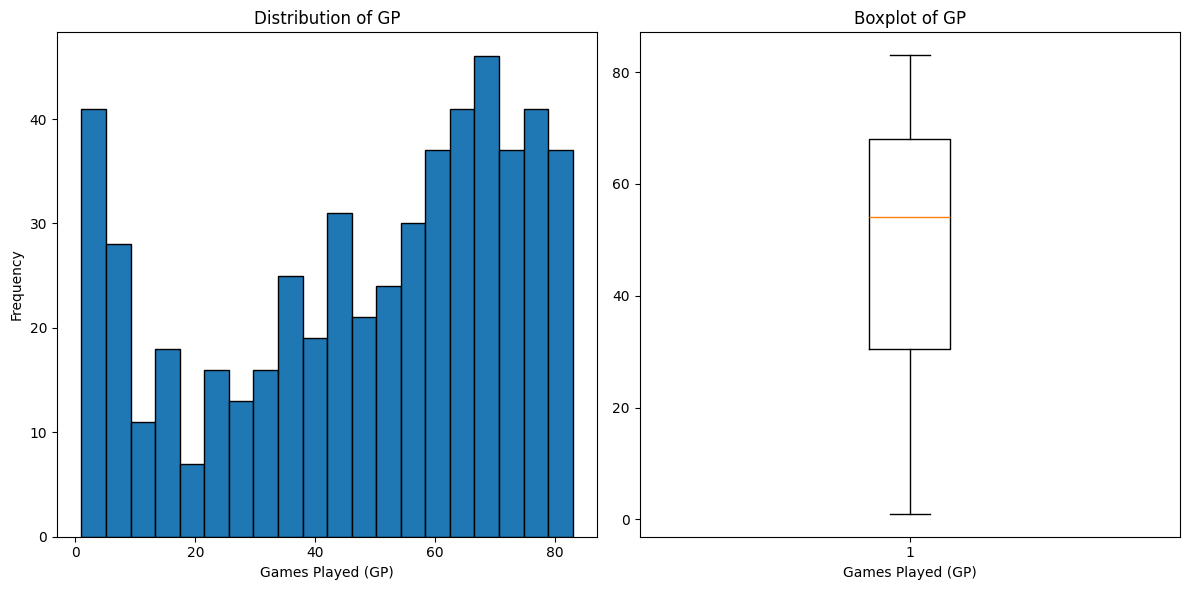

In [54]:
# Graphs of number of games played in the NBA

fig, axes = plt.subplots(1, 2, figsize=(12, 6))

axes[0].hist(df['GP'], bins=20, edgecolor='black')
axes[0].set_title('Distribution of GP')
axes[0].set_xlabel('Games Played (GP)')
axes[0].set_ylabel('Frequency')

axes[1].boxplot(df['GP'])
axes[1].set_title('Boxplot of GP')
axes[1].set_xlabel('Games Played (GP)')

plt.tight_layout()
plt.show()

__Analysis__:
The histogram reveals a peak around 60-80 games, which represents healthy players that are available for most of the season. There is another peak around 0-10 games, which represents lower level players who are signed to the team for a short amount of time before being cut. The other bars may represent injured players who are only able to play a limited amount of games throughout the season. The boxplot's slightly higher median and longer tail supports this.

### Different ages

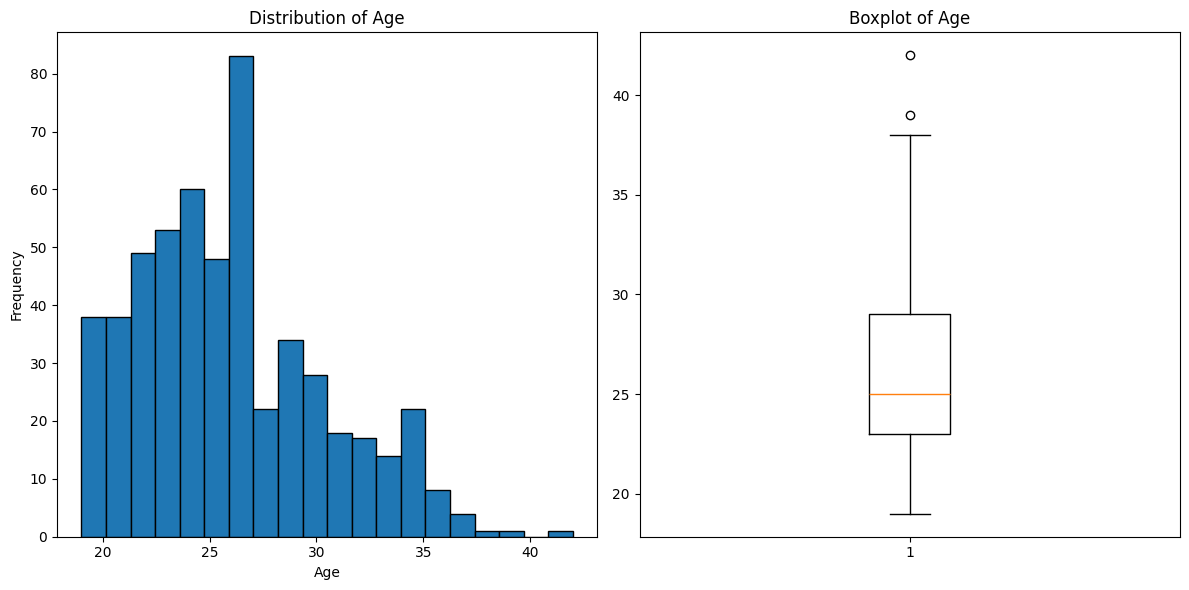

In [55]:
# Graphs of different ages in the NBA

fig, axes = plt.subplots(1, 2, figsize=(12, 6))

axes[0].hist(df['Age'], bins=20, edgecolor='black')
axes[0].set_title('Distribution of Age')
axes[0].set_xlabel('Age')
axes[0].set_ylabel('Frequency')

axes[1].boxplot(df['Age'])
axes[1].set_title('Boxplot of Age')

plt.tight_layout()
plt.show()

__Analysis:__ The histogram reveals that most players are 20-30, supported by the median in the boxplot. As players get older than 30, many cannot stay healthy or keep up with the younger players, demonstrating why there's less of them in the graphs.

### How age impacts performance (points, +/-, fantasy points)

(539, 46)
(535, 46)


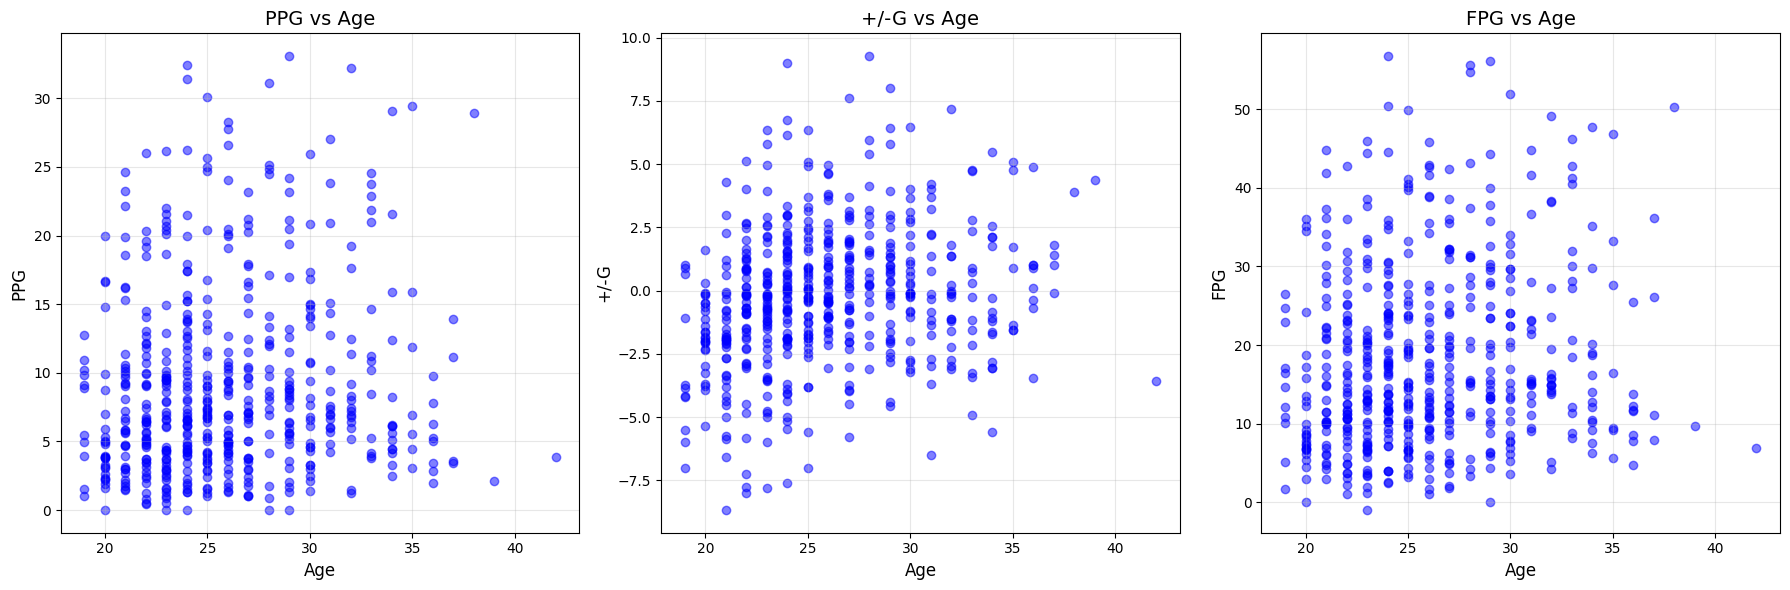

In [56]:
performance_stats = ['PPG', '+/-G', 'FPG']

# Clean data for +/- by removing outliers to show graph with improved scale
# Removed 4 players who only played a few games with extreme negative impact according to +/- metric

print(df.shape)
performance_plot_df = df[df['+/-G'] > -10]
print(performance_plot_df.shape)

fig, axes = plt.subplots(1, 3, figsize=(18, 6), sharey=False)

for i, stat in enumerate(performance_stats):
    axes[i].scatter(performance_plot_df['Age'], performance_plot_df[stat], alpha=0.5, color='blue')
    axes[i].set_title(f'{stat} vs Age', fontsize=14)
    axes[i].set_xlabel('Age', fontsize=12)
    axes[i].set_ylabel(stat, fontsize=12)
    axes[i].grid(alpha=0.3)

plt.tight_layout()
plt.show()

__Analysis:__ Age is not necessarily a great indicator for how players will perform, as only those who are still able to contribute to the team's success remain in the NBA, making them have similar performance statistics to the younger players. The older players who are worse than the younger players are not represented in the data because of the NBA's quickness to replace players. However, it demonstrates the abundance of younger players aged 20-30, and how those who are 30+ are mostly star players or solid role players that are able to continue to play.

### Distribution of performance statistics across players for teams

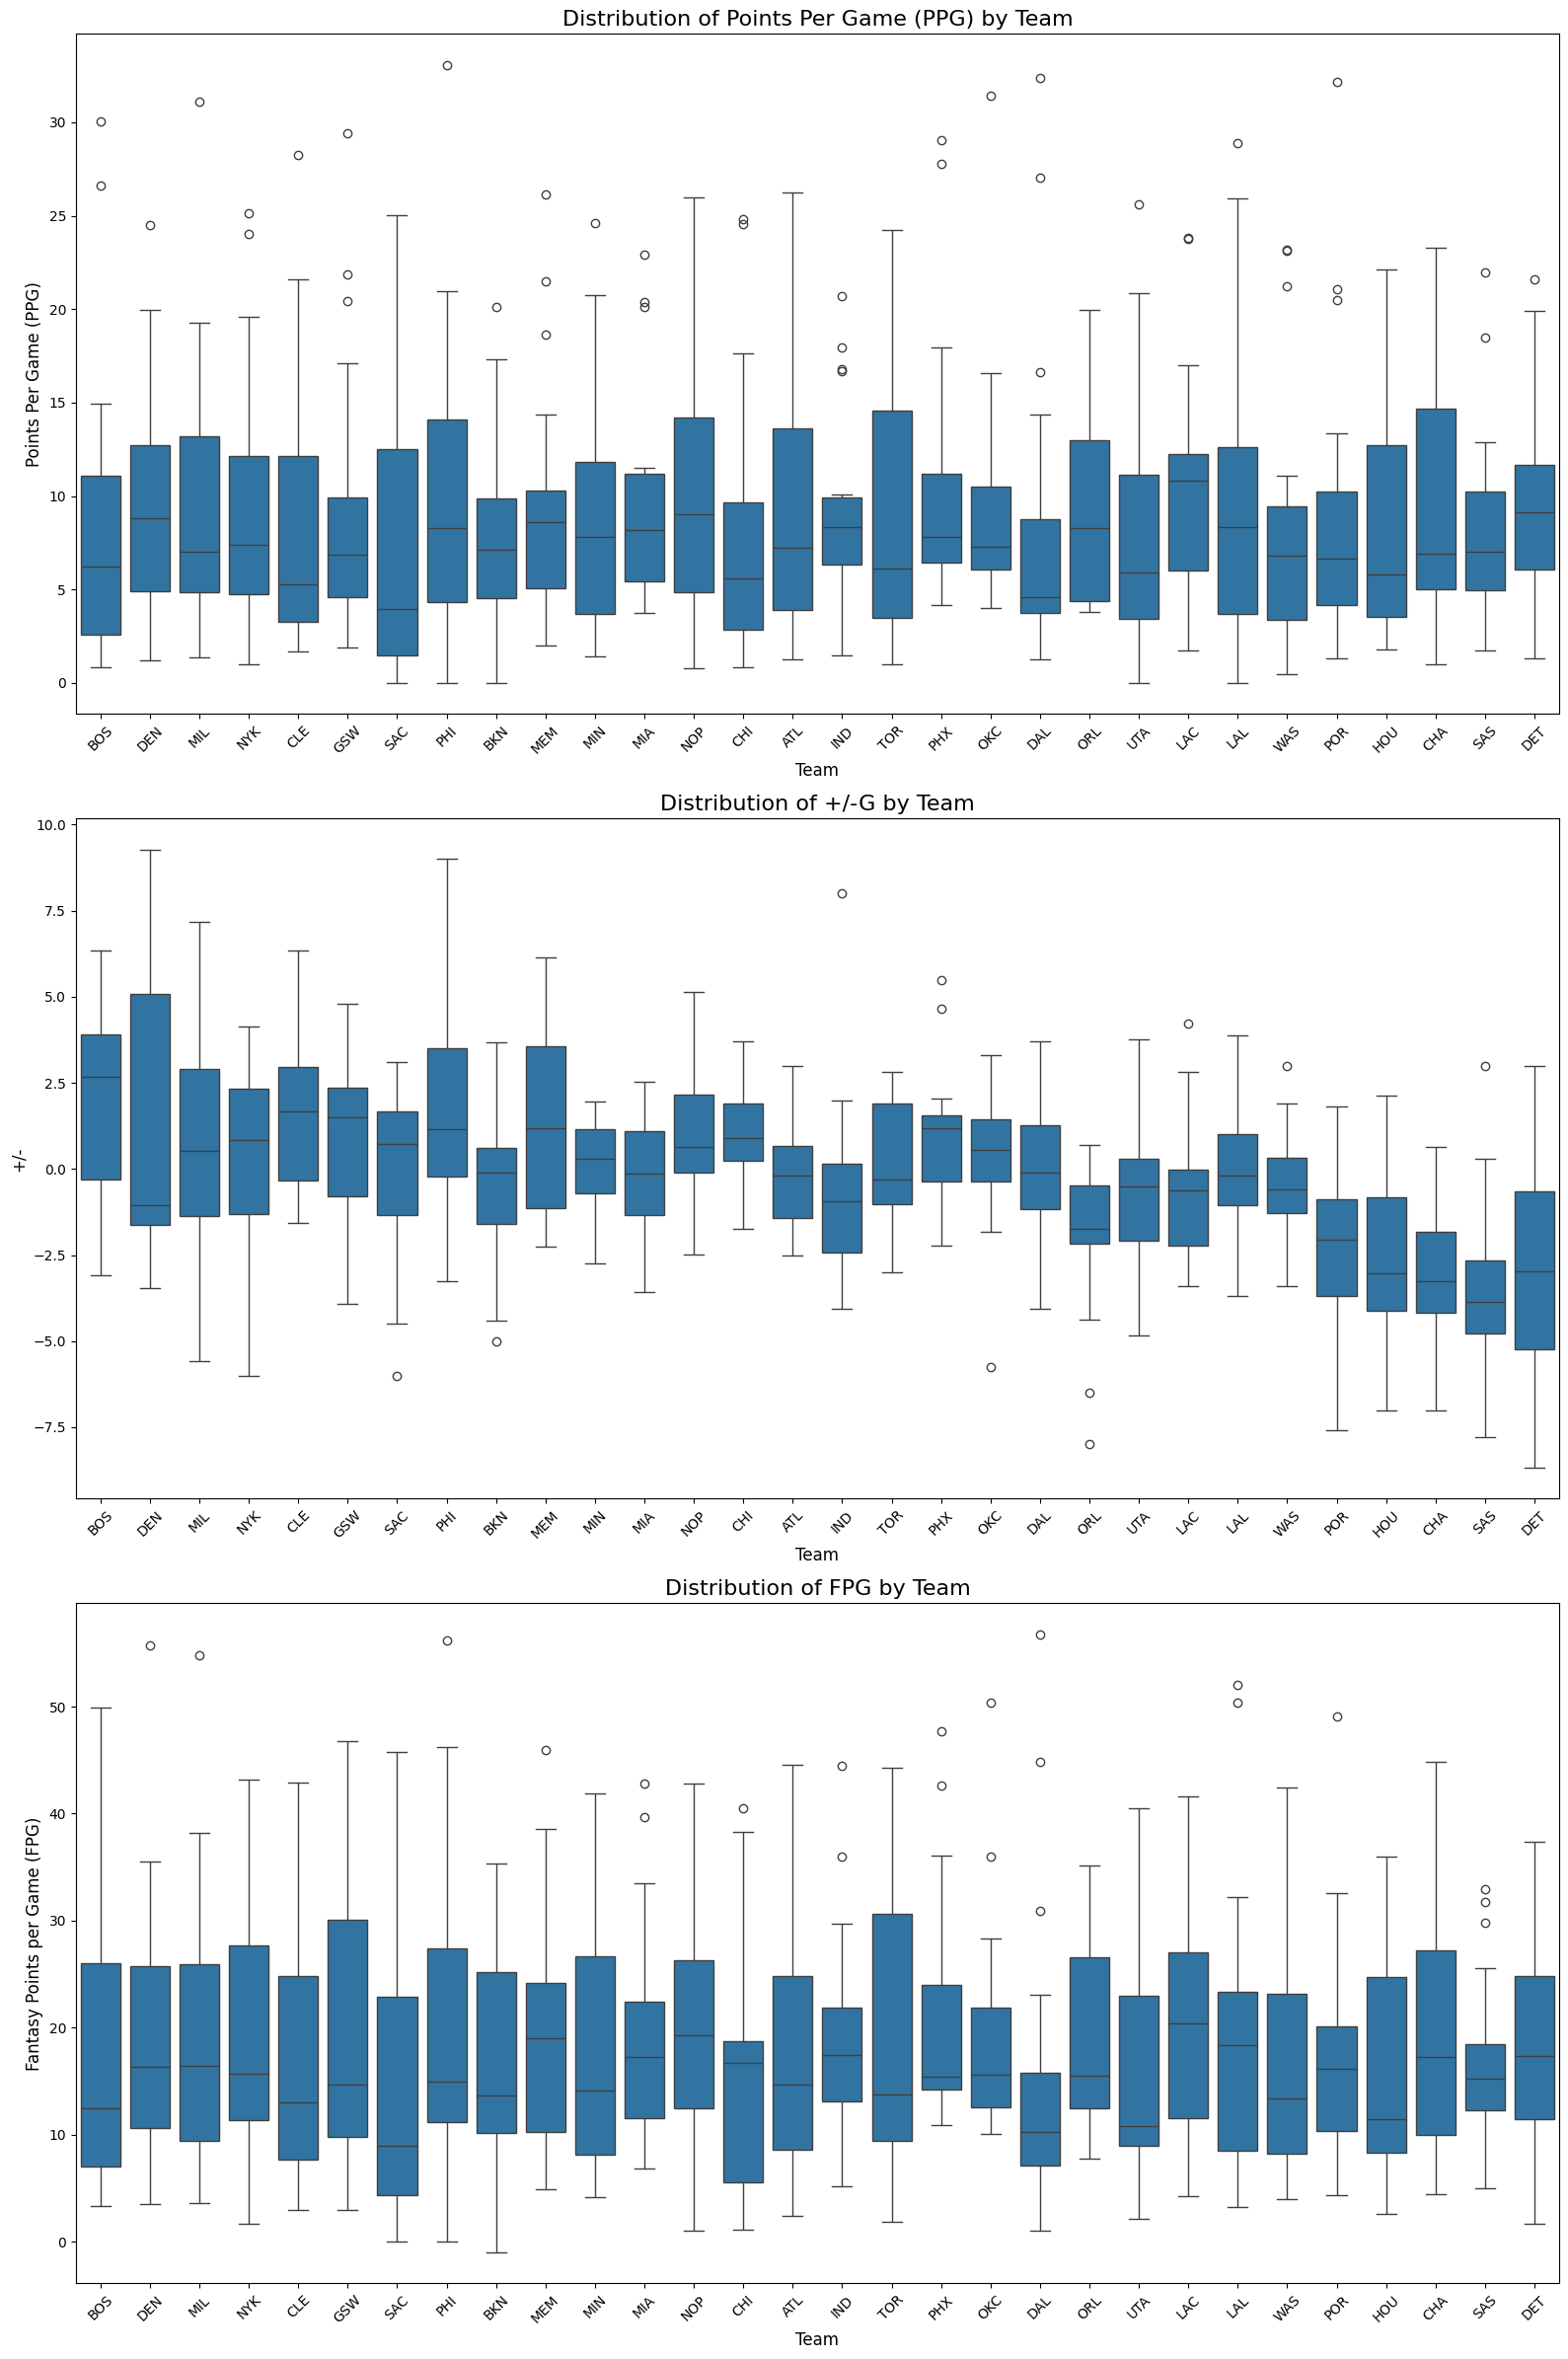

In [57]:
team_wins = df.drop_duplicates(subset="Team")[["Team", "W"]].set_index("Team")["W"]
sorted_teams = team_wins.sort_values(ascending=False).index

performance_plot_df = df[df['+/-G'] > -10].copy()
performance_plot_df["Team"] = pd.Categorical(performance_plot_df["Team"], categories=sorted_teams, ordered=True)

plt.figure(figsize=(16, 24))

# Boxplot for PPG
plt.subplot(3, 1, 1)
sns.boxplot(
    data=performance_plot_df,
    x="Team",
    y="PPG",
    order=sorted_teams,
)
plt.title("Distribution of Points Per Game (PPG) by Team", fontsize=16)
plt.xlabel("Team", fontsize=12)
plt.ylabel("Points Per Game (PPG)", fontsize=12)
plt.xticks(rotation=45)

# Boxplot for +/-G
plt.subplot(3, 1, 2)
sns.boxplot(
    data=performance_plot_df,
    x="Team",
    y="+/-G",
    order=sorted_teams,
)
plt.title("Distribution of +/-G by Team", fontsize=16)
plt.xlabel("Team", fontsize=12)
plt.ylabel("+/-", fontsize=12)
plt.xticks(rotation=45)

# Boxplot for FPG
plt.subplot(3, 1, 3)
sns.boxplot(
    data=performance_plot_df,
    x="Team",
    y="FPG",
    order=sorted_teams,
)
plt.title("Distribution of FPG by Team", fontsize=16)
plt.xlabel("Team", fontsize=12)
plt.ylabel("Fantasy Points per Game (FPG)", fontsize=12)
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

__Analysis:__ These plots reveal the identity/makeup of certain teams. They are ordered based on wins, which can be seen through the +/- graph, it shows boxplots that have lower values as you move to the right.

In these graphs, the prescence of "star players" is more pronounced. Looking at the graph showing fantasy points, which is a relatively accurate measure of overall contributions to the team, Boston (BOS) has no outliers, demonstrating how their well-roundedness leads to their success. Denver (DEN) and Milwaukee (MIL), on the other hand, both have a single, very high achieving player that carries their team's load and gives them success. Throughout the lower-achieving teams, there are players considered outliers for their team, but are not necessarily at a level high enough to produce success similar to Denver (DEN), Milwaukee (MIL), or other high-achieving teams.

Addditionally, the graph showing points demonstrates the necessity of having a few high volume scorers for each team, as these teams often turn to these players during close games to carry the team's scoring. These players may not excel in other aspects of the game (hence why there are more outliers in the points graph compared to the fantasy graph), however, the fact that most teams have at least one demonstrates that it is crucial to have players who can consistently carry the load in terms of scoring.

# Principal Component Analysis

## PCA on Player Position

__Overview:__ My goal in this section was to use reduce the dimensionality of various performance features using PCA and analyze how distinctions among player positions emerged across these principal components. This is achieved by creating principal components from all features that capture the majority of the variability in the data. In theory, this process highlights distinct patterns corresponding to different positions, as the variability between features reflects the inherent differences among positions.

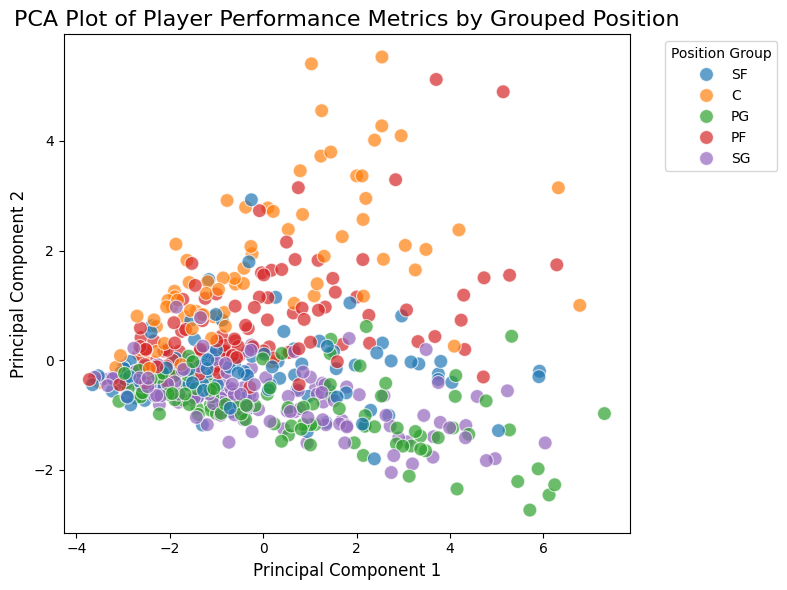

In [58]:
# Using PPG, RPG, APG, SPG, BPG, TPG, and FPG as features for PCA to reduce down to 2 dim
# Selected based on summary statistics based on position - these features should create
# noticeable variability in terms of the 3 positions

features = ['PPG', 'RPG', 'APG', 'SPG', 'BPG', 'TPG', 'FPG', '3PAG']
df_pca = df[features + ['POS_grouped']].dropna()

# Normalize
scaler = StandardScaler()
scaled_features = scaler.fit_transform(df_pca[features])

# PCA
pca = PCA(n_components=2)
pca_components = pca.fit_transform(scaled_features)

pca_df = pd.DataFrame(pca_components, columns=['PC1', 'PC2'])
pca_df['POS_grouped'] = df_pca['POS_grouped']

# Visualize
plt.figure(figsize=(8, 6))
sns.scatterplot(
    data=pca_df,
    x='PC1', y='PC2',
    hue='POS_grouped',
    s=100,
    alpha=0.7
)
plt.title('PCA Plot of Player Performance Metrics by Grouped Position', fontsize=16)
plt.xlabel('Principal Component 1', fontsize=12)
plt.ylabel('Principal Component 2', fontsize=12)
plt.legend(title='Position Group', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

### Explained variance for each component

In [59]:
print("Explained variance for each component:")
print(f"PC1: {pca.explained_variance_ratio_[0]:.2%}")
print(f"PC2: {pca.explained_variance_ratio_[1]:.2%}")

Explained variance for each component:
PC1: 63.48%
PC2: 17.44%


### Features that make up each component

In [60]:
components = pd.DataFrame(
    pca.components_,
    columns=features,
    index=['PC1', 'PC2']
)

print("Features that make up each component:")
print(components)

Features that make up each component:
          PPG       RPG       APG       SPG       BPG       TPG       FPG  \
PC1  0.416931  0.323143  0.370342  0.325854  0.186395  0.403893  0.438301   
PC2 -0.056788  0.481740 -0.262713 -0.137852  0.698114 -0.070210  0.077665   

         3PAG  
PC1  0.297376  
PC2 -0.422321  


__Analysis:__ The PCA graph visualizes player performance metrics (PPG, RPG, APG, SPG, BPG, TPG, and FPG) reduced to two principal components, grouped by position categories (F - Forwards, C - Centers, G - Guards). The plot highlights how players cluster based on similarities in their statistical profiles, reflecting variability and patterns specific to their roles.

PC1, explaining 63% of the variance, is heavily influenced by scoring (PPG = 0.42), turnovers (TPG = 0.41), fantasy points (FPG = 0.44), and assists (APG = 0.37), capturing overall offensive contribution and activity. PC2, explaining 17% of the variance, places more weight on rebounds (RPG = 0.48) and blocks (BPG = 0.70) while negatively correlating with assists (APG = -0.26) and steals (SPG = -0.14), emphasizing specialization in defensive and interior roles. Together, these components highlight how interior-focused players like centers, followed by forwards, excel in PC2 metrics, while guards and forwards distinguish themselves along PC1 by their offensive versatility.

While the positions saw moderate separation from one another, they weren't very distinct. Because most of the variance across the features were captured by the two components, it is likely that more advanced statistics are needed to create distinctions between players in different positions. It is also likely that modern players have evolved their game to be more alike one another, eliminating the distinct differences between positions that existed during the earlier years of basketball.

## PCA on general statistics

My goal in this section is to use the same set of relevant features, along with an encoded position, in order to create clusters for different types of players beyond their position. As we previously saw, players' positions no longer strictly indicate how they play. With this in mind, I wanted to inspect the different types of players that would be separated through clusters, which can be visualized on a 2D scale using PCA.

### Create numerical representations for positions

In [61]:
# Map simplified positions to numbers

position_mapping = {
    'PG': 1,
    'SG': 2,
    'SF': 3,
    'PF': 4,
    'C': 5,
}

pca_df = df.dropna(subset=['POS_grouped']).copy()

# Encode position based on defined mapping
pca_df['POS_encoded'] = pca_df['POS_grouped'].map(position_mapping)

### Create principal components using selected features

In [62]:
# Use most relevant features for PCA to reduce
df_features = pca_df[['PPG', 'RPG', 'APG', 'SPG', 'BPG', 'TPG', 'FPG', 'POS_encoded', '3PAG']]

# Normalize
scaler = StandardScaler()
scaled_features = scaler.fit_transform(df_features)

# PCA
pca = PCA(n_components=2)
pca_components = pca.fit_transform(scaled_features)

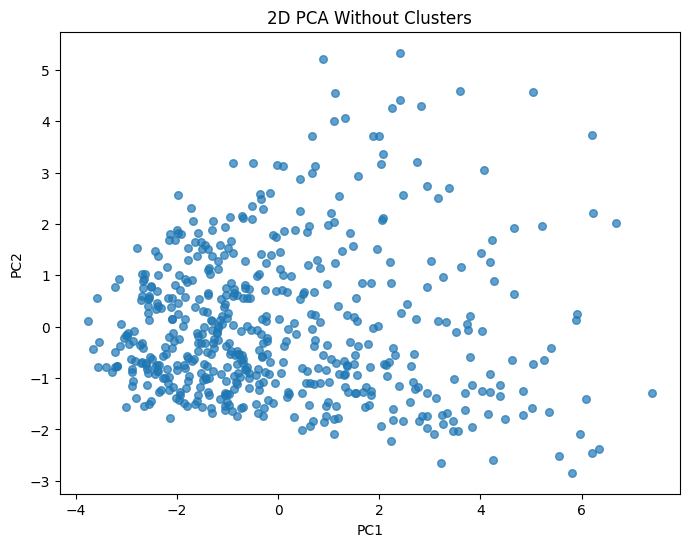

In [63]:
# Visualize
plt.figure(figsize=(8, 6))
plt.scatter(pca_components[:, 0], pca_components[:, 1], s=30, alpha=0.7)
plt.title("2D PCA Without Clusters")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.show()

### Elbow method and silhouette scores to determine optimal k

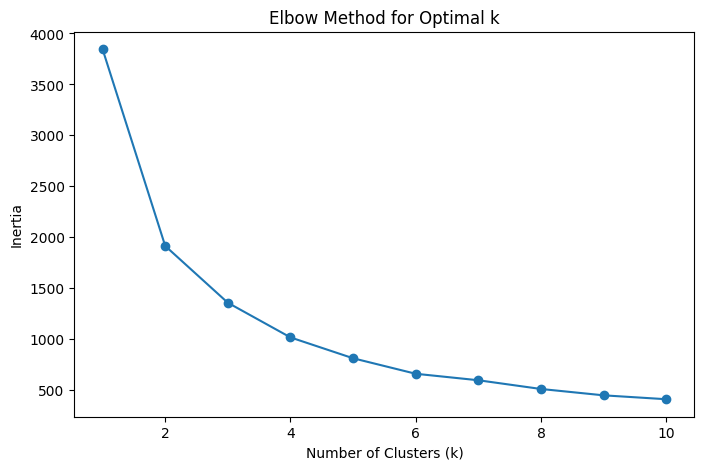

In [64]:
# Calculate intertia values for different k's
inertia = []
k_values = range(1, 11)
for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(pca_components)
    inertia.append(kmeans.inertia_)

# Plot elbow scores
plt.figure(figsize=(8, 5))
plt.plot(k_values, inertia, 'o-')
plt.title("Elbow Method for Optimal k")
plt.xlabel("Number of Clusters (k)")
plt.ylabel("Inertia")
plt.show()

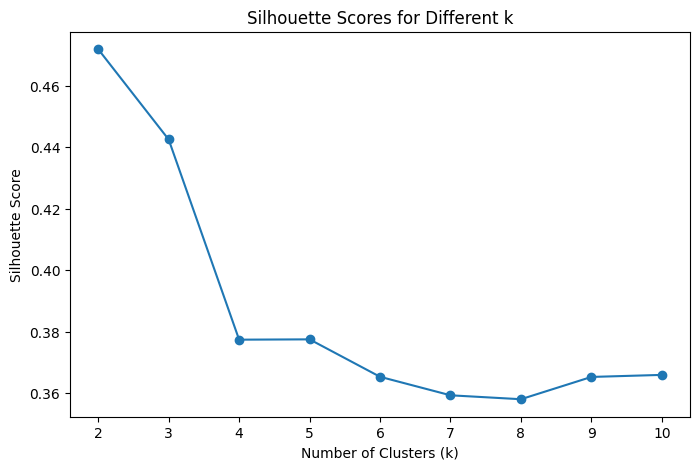

In [65]:
# Calculate silhouette scores for different k's
# Use seed/random_state = 42
silhouette_scores = []
for k in range(2, 11):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(pca_components)
    score = silhouette_score(pca_components, kmeans.labels_)
    silhouette_scores.append(score)

# Plot silhouette scores
plt.figure(figsize=(8, 5))
plt.plot(range(2, 11), silhouette_scores, 'o-')
plt.title("Silhouette Scores for Different k")
plt.xlabel("Number of Clusters (k)")
plt.ylabel("Silhouette Score")
plt.show()

### Clustering with k=3

I am choosing to select k=3. Although using 2 clusters has a higher silhouette score, 3 clusters provides better distinctions between groups that are obscurred when only using 2. Additionally, there is enough complexity in player performances across the NBA such that 2 groups is an overgeneralization, and fails to capture to full variability of the data. Lastly, the difference in silhouette scores is small, meaning that 3 clusters does not significanttly compromise clustering quality.

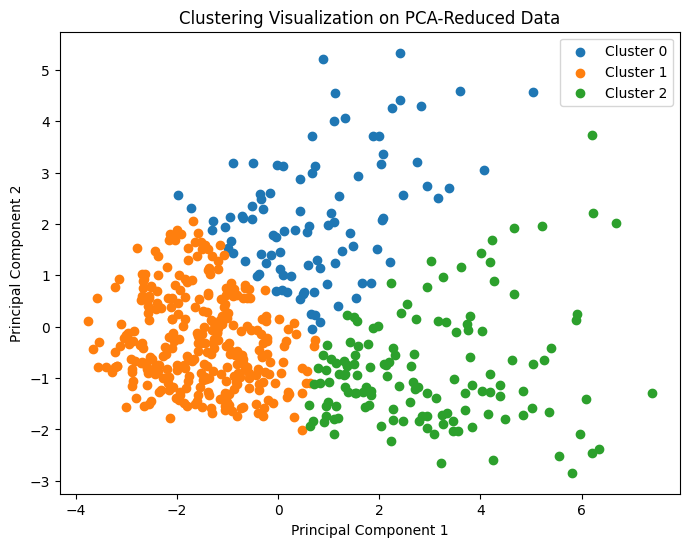

Silhouette Score for k=3: 0.44


In [66]:

optimal_k = 3
kmeans = KMeans(n_clusters=optimal_k, random_state=42)
kmeans.fit(pca_components)
cluster_labels = kmeans.labels_

# Cluster labels to original data
pca_df['Cluster'] = cluster_labels.copy()

# Plot clusters on PCA graph
plt.figure(figsize=(8, 6))
for cluster in np.unique(cluster_labels):
    plt.scatter(
        pca_components[cluster_labels == cluster, 0],
        pca_components[cluster_labels == cluster, 1],
        label=f"Cluster {cluster}"
    )
plt.title("Clustering Visualization on PCA-Reduced Data")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.legend()
plt.show()

# Silhouette score
final_score = silhouette_score(pca_components, cluster_labels)
print(f"Silhouette Score for k={optimal_k}: {final_score:.2f}")

In [67]:
cluster_means = pca_df.groupby('Cluster')[['GP', 'Age', 'Min', 'PPG', 'RPG', 'APG', 'TPG', 'SPG', 'BPG', 'FG%', 'FGAG', '3P%', '3PAG', 'FT%', 'FTAG', 'POS_encoded']].mean()

display(cluster_means)

,GP,Age,Min,PPG,RPG,APG,TPG,SPG,BPG,FG%,FGAG,3P%,3PAG,FT%,FTAG,POS_encoded
Cluster,,,,,,,,,,,,,,,,
0,61.680851,25.617021,24.131008,10.505273,6.401953,1.631307,1.213249,0.630320,0.902671,54.162766,7.699286,27.914894,1.996750,68.960638,2.319919,4.393617
1,38.330097,25.731392,13.543991,4.922082,2.140850,1.069973,0.611771,0.413827,0.213594,43.905178,4.091862,30.694498,1.943994,69.348867,0.843390,2.737864
2,60.676471,26.757353,31.006922,17.695776,4.744365,4.637643,2.146462,1.031649,0.397101,46.406618,13.533324,35.929412,5.232272,80.098529,3.835814,2.080882


In [68]:
loadings = pd.DataFrame(pca.components_, columns=df_features.columns, index=['PC1', 'PC2'])
print(loadings)

          PPG       RPG       APG       SPG       BPG       TPG       FPG  \
PC1  0.416571  0.316364  0.373643  0.327829  0.179058  0.404125  0.436731   
PC2 -0.011125  0.421488 -0.220347 -0.127911  0.528972 -0.037973  0.082497   

     POS_encoded      3PAG  
PC1    -0.050364  0.301086  
PC2     0.618439 -0.294593  


__Analysis__: The PCA graph visualizes player performance metrics ('PPG', 'RPG', 'APG', 'SPG', 'BPG', 'TPG', 'FPG', 'POS_encoded', '3PA') reduced to two principal components and clustered into 3 groups.

Cluster 0 has the lowest averages across most metrics, suggesting these players have limited playing time and lower overall impact.

Cluster 1 represents players that are most likely forwards or centers. This is most evident with the higher position value (POS_encoded), which corresponds to forwards and centers. They have higher rebounds (RPG), blocks (BPG), field-goal percentages (FG%), but lower three-point percentages (3P%) and free-throw percentages (FT%), which aligns the role of tall centers that rebound, block shots, and take shots close to the rim, but struggle with shooting from further away.

Cluster 2 represents players that are most likely guards. This is most evident with the low position value (POS_encoded), which corresponds to guards. Additionally, they have higher averages in scoring-related metrics such as points (PPG), assists (APG), field-goal attempts (FGAG), three-point attempts (3PAG), and free-throw attempts (FTAG), indicating high involvement in offensive plays, which aligns with their role as an offensive facilitator. They also have higher three-point percentages (3P%) and free throw percentages (FT%), but lower rebounds (RPG), blocks (BPG), and field-goal percentage (FG%), which is common with guards that shoot better from farther away, but struggle with rebounding, blocking, and shooting at closer field goal distances given their shorter height.

The PCA loadings indicate that PC1 captures high positive weights from PPG, APG, TPG, and 3PAG, reflecting primarily offensive contributions. Meanwhile, PC2 is strongly influenced by POS_encoded (0.63) and defensive metrics like RPG (0.41) and BPG (0.53), emphasizing positional and defensive attributes.

__Notes:__     
As expected, PCA and clustering did not separate players based on positions, instead using it as a way to determine different types/roles of players in the NBA beyond their labeled position.

### Clustering with k=10

Although k=10 results in a slightly lower silhouette score than other values, it captures finer distinctions in the data that reflect the diverse styles, roles, and positions within basketball. I will use k=10 to create a 'Cluster' column to help with my classification model later in the project.

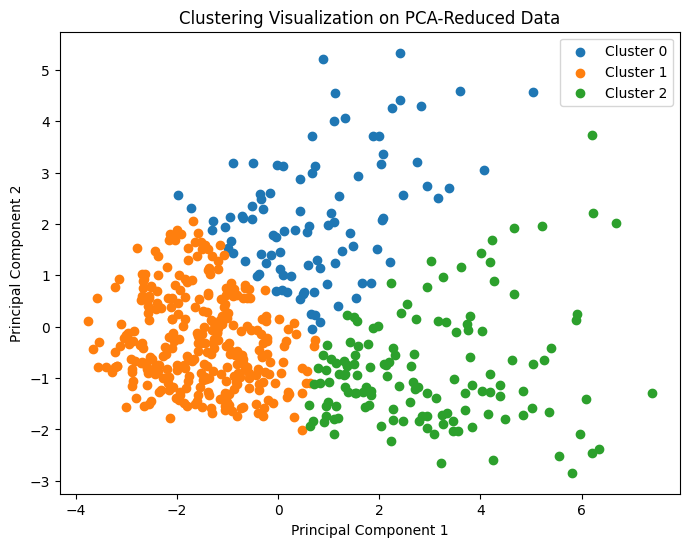

Silhouette Score for k=3: 0.44


In [69]:
optimal_k = 3
kmeans = KMeans(n_clusters=optimal_k, random_state=42)
kmeans.fit(pca_components)
cluster_labels = kmeans.labels_

# Cluster labels to original data
pca_df['Cluster'] = cluster_labels

# Plot clusters on PCA graph
plt.figure(figsize=(8, 6))
for cluster in np.unique(cluster_labels):
    plt.scatter(
        pca_components[cluster_labels == cluster, 0],
        pca_components[cluster_labels == cluster, 1],
        label=f"Cluster {cluster}"
    )
plt.title("Clustering Visualization on PCA-Reduced Data")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.legend()
plt.show()

# Silhouette score
final_score = silhouette_score(pca_components, cluster_labels)
print(f"Silhouette Score for k={optimal_k}: {final_score:.2f}")

In [70]:
cluster_means = pca_df.groupby('Cluster')[['GP', 'Age', 'Min', 'PPG', 'RPG', 'APG', 'TPG', 'SPG', 'BPG', 'FG%', 'FGAG', '3P%', '3PAG', 'FT%', 'FTAG', 'POS_encoded']].mean()

display(cluster_means)

,GP,Age,Min,PPG,RPG,APG,TPG,SPG,BPG,FG%,FGAG,3P%,3PAG,FT%,FTAG,POS_encoded
Cluster,,,,,,,,,,,,,,,,
0,61.680851,25.617021,24.131008,10.505273,6.401953,1.631307,1.213249,0.630320,0.902671,54.162766,7.699286,27.914894,1.996750,68.960638,2.319919,4.393617
1,38.330097,25.731392,13.543991,4.922082,2.140850,1.069973,0.611771,0.413827,0.213594,43.905178,4.091862,30.694498,1.943994,69.348867,0.843390,2.737864
2,60.676471,26.757353,31.006922,17.695776,4.744365,4.637643,2.146462,1.031649,0.397101,46.406618,13.533324,35.929412,5.232272,80.098529,3.835814,2.080882


In [71]:
loadings = pd.DataFrame(pca.components_, columns=df_features.columns, index=['PC1', 'PC2'])
print(loadings)

          PPG       RPG       APG       SPG       BPG       TPG       FPG  \
PC1  0.416571  0.316364  0.373643  0.327829  0.179058  0.404125  0.436731   
PC2 -0.011125  0.421488 -0.220347 -0.127911  0.528972 -0.037973  0.082497   

     POS_encoded      3PAG  
PC1    -0.050364  0.301086  
PC2     0.618439 -0.294593  


__Analysis:__ The PCA graph visualizes player performance metrics ('PPG', 'RPG', 'APG', 'SPG', 'BPG', 'TPG', 'FPG', 'POS_encoded', '3PA') reduced to two principal components and clustered into 10 groups.

__Star players:__     
Clusters 2 and 6 captures star players due to their higher minutes, higher points, higher field goal attempts and free throw attempts. Cluster 6 captures star forwards/centers, shown by higher rebounds, blocks, field-goal percentage, and high positional value. Custer 2 captures star guards, shown by higher assists, 3P%, FT%, and lower positional value. Forwards and centers are grouped together here, because on a high level, forwards and centers may contribute similar statistics and are less differentiable, especially given the modern emphasis on centers playing more like guards and forwards.

__Lower level players fighting for spot on the team:__    
Clusters 3 and 9 captures lower-level players that struggle to make the lineup and don't play much in games due to their lower minutes, games played, and lower general statistics. Cluster 9 captures forwards and centers, while cluster 3 captures guards, demonstrated by their respective positional value.

__Starting lineup level players:__    
Cluster 5 captures solid level guards - guards in the starting lineup - due to their low positional value and medium/high minutes. Their medium/high points, assists, 3P%, and FT% support this.

Cluster 0 captures solid level forwards - forwards in the starting lineup - due to their medium positional value and medium/high minutes. Their medium points, assists, 3P%, FT%, rebounds, blocks, and FG% support this, as forwards are a "middle ground" between guards and centers, and can thus do what guards and centers excel at at a medium level.

Cluster 4 captures solid level centers - centers in the starting lineup - due to their high positional value and medium/high minutes. Their medium/high points, rebounds, blocks, and FG% support this.

__Bench level players:__     
Cluster 7 captures bench level guards due to their low positional value and medium/low minutes. Their medium/low points, assists, 3P%, and FT% support this.

Cluster 1 captures bench level forwards due to their medium positional value and medium/low minutes. Their medium/low points, assists, 3P%, FT%, rebounds, blocks, and FG% support this, as forwards are a "middle ground" between guards and centers, and can thus do what guards and centers excel at at a medium level.

Cluster 8 captures bench level centers due to their high positional value and medium/low minutes. Their medium/low points, rebounds, blocks, and FG% support this.

__PCA loadings:__   
The PCA loadings indicate that PC1 captures high positive weights from PPG (0.42), APG (0.37), TPG (0.41), and FPG (0.44), reflecting primarily offensive contributions. Meanwhile, PC2 is strongly influenced by POS_encoded (0.62) and defensive metrics like RPG (0.42) and BPG (0.53), emphasizing positional and defensive attributes.

__Notes:__    
Through these clusters, we can see how position plays a larger part on how players can be grouped. While it is not the only factor, it plays a significant role.

# Additional Exploration - Classification

### Multinomial Logistic Regression - Attempt 1

Multinomial logistic regression extends binary logistic regression to handle dependent variables with more than two categories. It models the probabilities of each class based on a linear combination of the independent variables. Here, the goal is to predict a player's position using all features in the dataset, including the cluster determined by the previous part. This approach allows us to classify players based on their play style and role on the court.

In [72]:
# Players must average at least 15 minutes a game, as any less time does not provide ample opportunity for players to
# accumulate statistics that reflect, or do not reflect, their position

pca_df = pca_df[pca_df['Min'] >= 15]

Accuracy: 0.5217391304347826

Classification Report:
              precision    recall  f1-score   support

           C       0.86      0.60      0.71        10
          PF       0.54      0.47      0.50        15
          PG       0.45      0.50      0.48        10
          SF       0.27      0.40      0.32        10
          SG       0.61      0.58      0.60        24

    accuracy                           0.52        69
   macro avg       0.55      0.51      0.52        69
weighted avg       0.56      0.52      0.53        69



/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


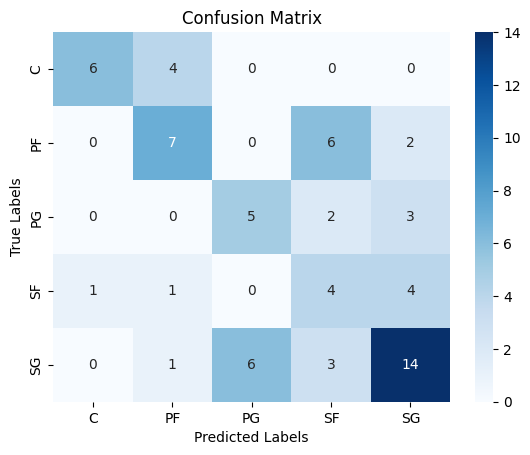

In [73]:
classification_df = pca_df.dropna(subset=['POS', 'POS_grouped'])
classification_df = classification_df.drop(columns=['FGA', '3PM', '3PA', 'FTM', 'FTA', 'OREB', 'DREB', 'REB', 'AST', 'TOV', 'STL', 'BLK', 'PF', 'FP', 'DD2', 'TD3', '+/-'])

# Define features and target - remove non-numerical features, as well as POS_encoded
# and POS_grouped, otherwise it would know the separate classes and predict perfectly
X = classification_df.drop(columns=['PName', 'Team', 'POS', 'POS_grouped', 'POS_encoded'])
y = classification_df['POS_grouped']

# Encode the target variable to transform 'G', 'F', 'C' to numeric classes
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, random_state=42)

# Normalize features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Train the logistic regression model
clf = LogisticRegression(max_iter=1000, multi_class='multinomial', solver='lbfgs')
clf.fit(X_train, y_train)

# Make predictions
y_pred = clf.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

# Classification Report
print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=label_encoder.classes_))

# Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred)
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.title("Confusion Matrix")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()

* C (Center): Achieved the best performance with a high precision of 0.86 and an F1-score of 0.71. However, the recall is 0.60, indicating that while predictions for "C" are mostly correct, the model misses 40% of true instances.

* PF (Power Forward): Moderate performance with a precision of 0.54 and an F1-score of 0.50, reflecting challenges in capturing all true instances (recall of 0.47).

* PG (Point Guard): Balanced but low metrics, with an F1-score of 0.48, indicating difficulty in distinguishing this class.

* SF (Small Forward): Struggles the most, with a precision of 0.27 and an F1-score of 0.32, highlighting significant misclassifications.

* SG (Shooting Guard): Performed relatively well, with the highest support (24 instances), achieving a precision of 0.61 and an F1-score of 0.60, suggesting better generalization for this class.

* Overall Accuracy (0.52): Reflects poor balance in performance across classes, with weaker metrics for "SF" and "PG" pulling down the average.

* The model performs better for classes with clearer features ("C" and "SG"), while it struggles with overlapping or less distinct features for "PF," "PG," and "SF."

* Low recall for several classes suggests that the model is failing to identify many true positives, which impacts overall performance.

### Fully Connected Neural Network - Attempt 1

In [74]:
from keras.models import Sequential
from keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout, BatchNormalization
from keras.optimizers import Adam
from keras.utils import to_categorical


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/150
5/5 ━━━━━━━━━━━━━━━━━━━━ 4s 79ms/step - accuracy: 0.2278 - loss: 2.2057 - val_accuracy: 0.3043 - val_loss: 1.5643
Epoch 2/150
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.2821 - loss: 1.8340 - val_accuracy: 0.3478 - val_loss: 1.5050
Epoch 3/150
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.3576 - loss: 1.5952 - val_accuracy: 0.3768 - val_loss: 1.4612
Epoch 4/150
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.3900 - loss: 1.5184 - val_accuracy: 0.4348 - val_loss: 1.4236
Epoch 5/150
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.4547 - loss: 1.4132 - val_accuracy: 0.4638 - val_loss: 1.3935
Epoch 6/150
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.5066 - loss: 1.3221 - val_accuracy: 0.4928 - val_loss: 1.3654
Epoch 7/150
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.4321 - loss: 1.2991 - val_accuracy: 0.4783 - val_loss: 1.3406
Epoch 8/150
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.5043 - loss: 1.2641 - val_accuracy: 0.5217 - val_loss:

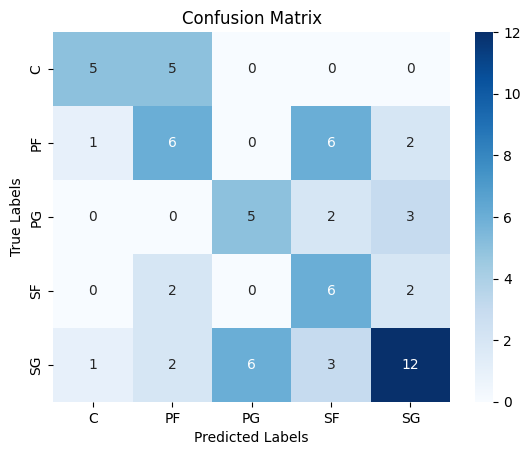

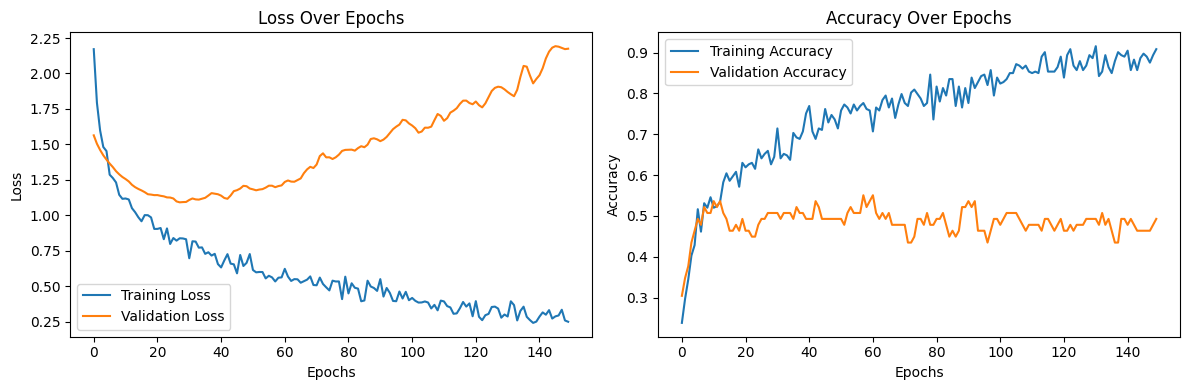

In [75]:
X = classification_df.drop(columns=['PName', 'Team', 'POS', 'POS_grouped', 'POS_encoded'])
y = classification_df['POS_grouped']

# Encode the target variable to transform 'G', 'F', 'C' to numeric classes
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, random_state=42)

# Standardize the data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# One-hot encode the target variable
y_train_onehot = to_categorical(y_train)
y_test_onehot = to_categorical(y_test)

# Build the neural network model
model = Sequential([
    Dense(256, input_dim=X_train_scaled.shape[1], activation='relu'),
    BatchNormalization(),
    Dropout(0.4),
    Dense(128, activation='relu'),
    BatchNormalization(),
    Dropout(0.3),
    Dense(64, activation='relu'),
    Dropout(0.3),
    Dense(len(np.unique(y_train)), activation='softmax')
])

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Train the model
history = model.fit(X_train_scaled, y_train_onehot,
                    validation_data=(X_test_scaled, y_test_onehot),
                    epochs=150,
                    batch_size=64,
                    verbose=1)

# Evaluate the model
eval_results = model.evaluate(X_test_scaled, y_test_onehot, verbose=0)
print(f"Test Accuracy: {eval_results[1]:.2f}")

# Make predictions
y_pred_probs = model.predict(X_test_scaled)
y_pred = y_pred_probs.argmax(axis=1)

# Classification Report
print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=LabelEncoder().fit(y).classes_))

# Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred)
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=LabelEncoder().fit(y).classes_, yticklabels=LabelEncoder().fit(y).classes_)
plt.title("Confusion Matrix")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()

# Plot training history
plt.figure(figsize=(12, 4))

# Loss plot
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Loss Over Epochs')

# Accuracy plot
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Accuracy Over Epochs')

plt.tight_layout()
plt.show()

Class Performance:

C (Center): The best-performing class, with high precision (0.86) but relatively low recall (0.60), indicating the model predicts this class accurately but misses several true instances.

PF (Power Forward), PG (Point Guard), and SF (Small Forward): These classes show low precision, recall, and F1-scores, reflecting difficulty in distinguishing these positions effectively.

SG (Shooting Guard): Moderate performance, with a precision of 0.71 but recall of 0.50, showing a similar pattern to the C class.
Macro vs. Weighted Averages:

The overall average of 0.51 indicates poor balance across all classes, with certain classes (e.g., SF) dragging down overall performance.

The model struggles with imbalanced support across classes, as some classes (e.g., PF, SF) have relatively low precision and recall. This is likely due to overlapping feaetures, as these positions often produce similar statistical performances.

### Convolutional Neural Network - Attempt 1

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/150
5/5 ━━━━━━━━━━━━━━━━━━━━ 6s 104ms/step - accuracy: 0.2680 - loss: 2.2499 - val_accuracy: 0.2754 - val_loss: 1.5838
Epoch 2/150
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.3812 - loss: 1.6179 - val_accuracy: 0.3333 - val_loss: 1.5487
Epoch 3/150
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.4733 - loss: 1.5100 - val_accuracy: 0.4203 - val_loss: 1.5147
Epoch 4/150
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.4567 - loss: 1.4439 - val_accuracy: 0.3188 - val_loss: 1.5062
Epoch 5/150
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.4716 - loss: 1.3669 - val_accuracy: 0.3188 - val_loss: 1.5031
Epoch 6/150
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.4651 - loss: 1.4234 - val_accuracy: 0.3043 - val_loss: 1.4974
Epoch 7/150
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.4847 - loss: 1.2849 - val_accuracy: 0.3478 - val_loss: 1.4910
Epoch 8/150
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.5055 - loss: 1.2092 - val_accuracy: 0.3188 - val_loss

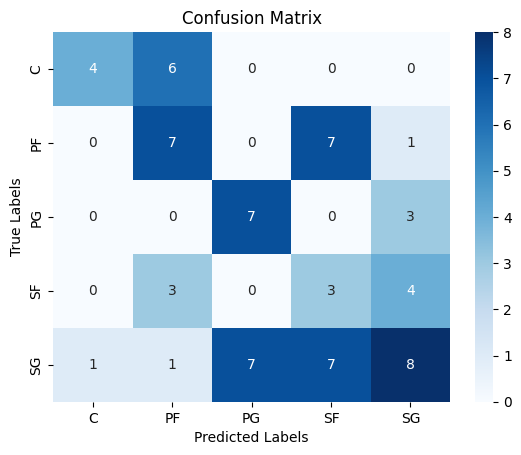

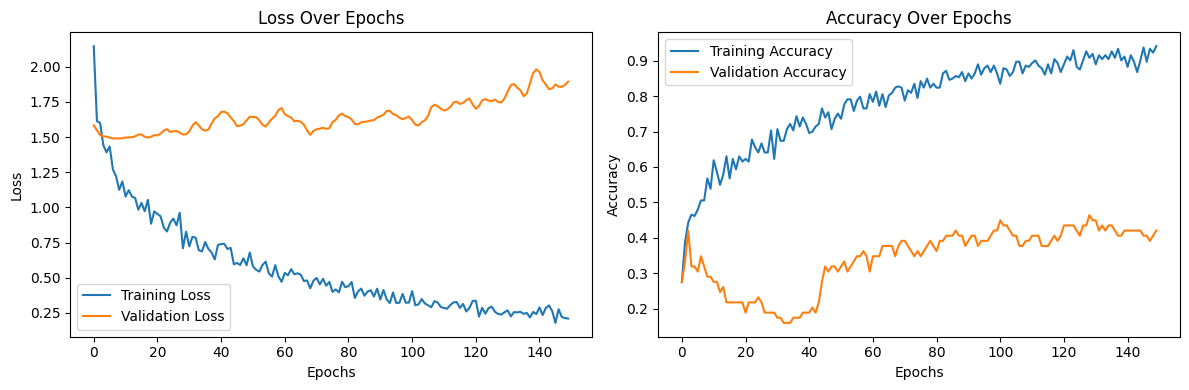

In [76]:
# Assuming 'classification_df' is preloaded
X = classification_df.drop(columns=['PName', 'Team', 'POS', 'POS_grouped', 'POS_encoded'])
y = classification_df['POS_grouped']

# Encode the target variable
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, random_state=42)

# Standardize the data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Reshape the data for CNN (add a channel dimension)
X_train_reshaped = X_train_scaled[..., np.newaxis]
X_test_reshaped = X_test_scaled[..., np.newaxis]

# One-hot encode the target variable
y_train_onehot = to_categorical(y_train)
y_test_onehot = to_categorical(y_test)

# Build the CNN model
model = Sequential([
    Conv1D(64, kernel_size=3, activation='relu', input_shape=(X_train_reshaped.shape[1], 1)),
    BatchNormalization(),
    MaxPooling1D(pool_size=2),
    Dropout(0.3),

    Conv1D(128, kernel_size=3, activation='relu'),
    BatchNormalization(),
    MaxPooling1D(pool_size=2),
    Dropout(0.3),

    Flatten(),
    Dense(128, activation='relu'),
    BatchNormalization(),
    Dropout(0.4),

    Dense(len(np.unique(y_train)), activation='softmax')
])

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Train the model
history = model.fit(X_train_reshaped, y_train_onehot,
                    validation_data=(X_test_reshaped, y_test_onehot),
                    epochs=150,
                    batch_size=64,
                    verbose=1)

# Evaluate the model
eval_results = model.evaluate(X_test_reshaped, y_test_onehot, verbose=0)
print(f"Test Accuracy: {eval_results[1]:.2f}")

# Make predictions
y_pred_probs = model.predict(X_test_reshaped)
y_pred = y_pred_probs.argmax(axis=1)

# Classification Report
print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=label_encoder.classes_))

# Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred)
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.title("Confusion Matrix")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()

# Plot training history
plt.figure(figsize=(12, 4))

# Loss plot
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Loss Over Epochs')

# Accuracy plot
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Accuracy Over Epochs')

plt.tight_layout()
plt.show()


C (Center): Achieves the best performance with a precision of 0.71 and an F1-score of 0.59. However, the recall is only 0.50, suggesting the model misses half of the true "C" instances.

PF (Power Forward): Poor performance, with a precision of 0.29 and an F1-score of 0.28, indicating limited ability to correctly identify this class.

PG (Point Guard): Performs relatively well with a recall of 0.70 and an F1-score of 0.61, showing that the model can identify most "PG" instances but with moderate precision (0.54).

SF (Small Forward): Lowest performance across all metrics, with a precision of 0.15 and an F1-score of 0.20, highlighting significant misclassifications.

SG (Shooting Guard): Moderate precision (0.53) but low recall (0.33), leading to an F1-score of 0.41.

Overall accuracy (0.39): Indicates that the model struggles across all classes, with poor balance in predictions.

The model struggles with imbalanced support across classes, as some classes (e.g., PF, SF) have relatively low precision and recall. This is likely due to overlapping feaetures, as these positions often produce similar statistical performances.

### Attempt 1 Conclusion
All 3 attempts for classification resulted in relatively mediocre accuracy. The most accurate model was the multinomial classification, which makes sense given the small nature of the dataset. Although it's better than a random guess, it isn't by much. One simple reason for this is a lack of enough data. After the initial filter of >15 minutes played is implemented, there are only 69*5 = 345 entries for the model to learn from. Add the modern positional ambiguity on to that, and you get a fairly poor model.

We can notice that the poor performance usually comes from primarily PG, SF, and PF, but never from C. This may be because the C is a more defined position, whereas the responsibilities and statistical performances of SF/PF, and PG/SG often overlap, resulting in poor predictive performance. In the next section, I will modify the classification task by grouping PG/SG and SF/PF in order to remove some of the ambiguity, and see how accurate we can get despite our relatively low amount of data.  

### Multinomial Logistic Regression Attempt 2

As previously mentioned, I will modify the classificaton task from 5 positions to 3. I will adjust the labeled positions of players, such that PG/SG are grouped as G, and SF/PF are grouped as F. Then, I will create the exact same classification models, starting with multinomial.

In [77]:
classification_df['POS_grouped'] = classification_df['POS_grouped'].replace({'SF': 'F', 'PF': 'F'})
classification_df['POS_grouped'] = classification_df['POS_grouped'].replace({'PG': 'G', 'SG': 'G'})

/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


Accuracy: 0.7971014492753623

Classification Report:
              precision    recall  f1-score   support

           C       1.00      0.60      0.75        10
           F       0.68      0.84      0.75        25
           G       0.88      0.82      0.85        34

    accuracy                           0.80        69
   macro avg       0.85      0.75      0.78        69
weighted avg       0.82      0.80      0.80        69



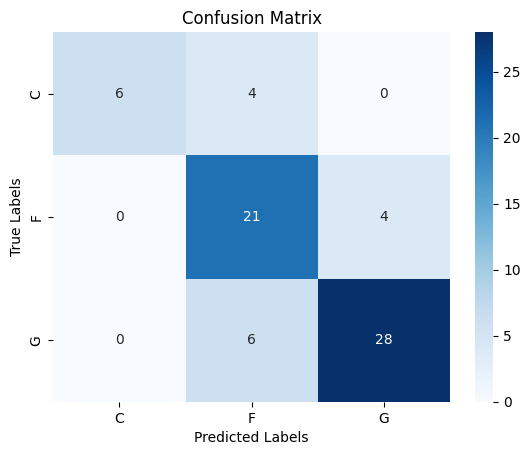

In [78]:
# Define features and target - remove non-numerical features, as well as POS_encoded
# and POS_grouped, otherwise it would know the separate classes and predict perfectly
X = classification_df.drop(columns=['PName', 'Team', 'POS', 'POS_grouped', 'POS_encoded'])
y = classification_df['POS_grouped']

# Encode the target variable to transform 'G', 'F', 'C' to numeric classes
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, random_state=42)

# Normalize features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Train the logistic regression model
clf = LogisticRegression(max_iter=1000, multi_class='multinomial', solver='lbfgs')
clf.fit(X_train, y_train)

# Make predictions
y_pred = clf.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

# Classification Report
print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=label_encoder.classes_))

# Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred)
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.title("Confusion Matrix")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()

Class-Level Performance:

* C (Center): High precision (1.00) indicates that when the model predicts "C," it is always correct. However, the recall is 0.60, suggesting the model misses 40% of true "C" instances, leading to an F1-score of 0.75.

* F (Forward): Balanced performance with a precision of 0.68 and recall of 0.84. The F1-score of 0.75 highlights the model's effectiveness in identifying "F" instances while maintaining moderate precision.

* G (Guard): Best-performing class, with a precision of 0.88 and recall of 0.82, resulting in a strong F1-score of 0.85.

Averages:

* Macro Average (F1-score: 0.78): Reflects an acceptable balance across classes, though slightly lower due to "C" having lower recall.

* Weighted Average (F1-score: 0.80): Indicates robust performance, with more weight given to "F" and "G" due to their larger support.

### Fully Connected Neural Network - Attempt 2

Epoch 1/150


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


5/5 ━━━━━━━━━━━━━━━━━━━━ 4s 116ms/step - accuracy: 0.5067 - loss: 1.4012 - val_accuracy: 0.6812 - val_loss: 0.9439
Epoch 2/150
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.5585 - loss: 1.0207 - val_accuracy: 0.6812 - val_loss: 0.8813
Epoch 3/150
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.6517 - loss: 0.8457 - val_accuracy: 0.7246 - val_loss: 0.8395
Epoch 4/150
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.6291 - loss: 0.8914 - val_accuracy: 0.7681 - val_loss: 0.8165
Epoch 5/150
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.7054 - loss: 0.6989 - val_accuracy: 0.7971 - val_loss: 0.7983
Epoch 6/150
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.6789 - loss: 0.6962 - val_accuracy: 0.7681 - val_loss: 0.7716
Epoch 7/150
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.7170 - loss: 0.6748 - val_accuracy: 0.8116 - val_loss: 0.7441
Epoch 8/150
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.6708 - loss: 0.7087 - val_accuracy: 0.7536 - val_loss: 0.7279
Epo

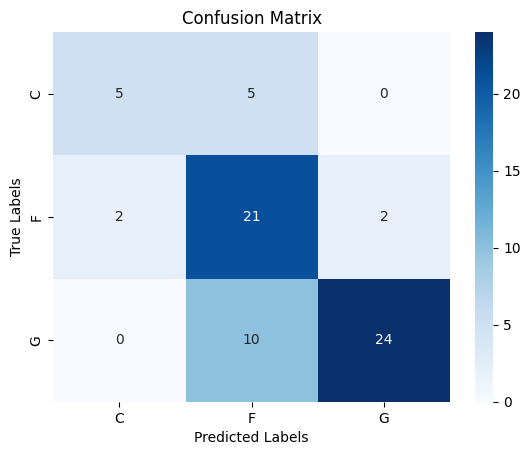

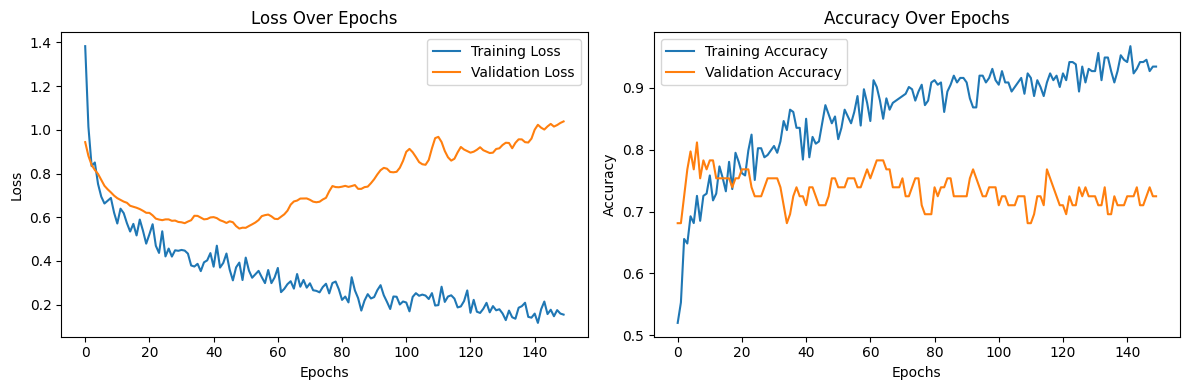

In [79]:
X = classification_df.drop(columns=['PName', 'Team', 'POS', 'POS_grouped', 'POS_encoded'])
y = classification_df['POS_grouped']

# Encode the target variable to transform 'G', 'F', 'C' to numeric classes
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, random_state=42)

# Standardize the data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# One-hot encode the target variable
y_train_onehot = to_categorical(y_train)
y_test_onehot = to_categorical(y_test)

# Build the neural network model
model = Sequential([
    Dense(256, input_dim=X_train_scaled.shape[1], activation='relu'),
    BatchNormalization(),
    Dropout(0.4),
    Dense(128, activation='relu'),
    BatchNormalization(),
    Dropout(0.3),
    Dense(64, activation='relu'),
    Dropout(0.3),
    Dense(len(np.unique(y_train)), activation='softmax')
])

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Train the model
history = model.fit(X_train_scaled, y_train_onehot,
                    validation_data=(X_test_scaled, y_test_onehot),
                    epochs=150,
                    batch_size=64,
                    verbose=1)

# Evaluate the model
eval_results = model.evaluate(X_test_scaled, y_test_onehot, verbose=0)
print(f"Test Accuracy: {eval_results[1]:.2f}")

# Make predictions
y_pred_probs = model.predict(X_test_scaled)
y_pred = y_pred_probs.argmax(axis=1)

# Classification Report
print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=LabelEncoder().fit(y).classes_))

# Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred)
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=LabelEncoder().fit(y).classes_, yticklabels=LabelEncoder().fit(y).classes_)
plt.title("Confusion Matrix")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()

# Plot training history
plt.figure(figsize=(12, 4))

# Loss plot
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Loss Over Epochs')

# Accuracy plot
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Accuracy Over Epochs')

plt.tight_layout()
plt.show()

Class-Level Performance:
* C (Center): Precision is 0.71, indicating a moderate ability to correctly identify "C" instances, but recall is lower at 0.50, meaning half of the true "C" instances are missed. This results in an F1-score of 0.59, highlighting room for improvement.

* F (Forward): Balanced performance with a recall of 0.84, showing the model captures most "F" instances. Precision is 0.58, indicating some false positives, leading to an F1-score of 0.69.

* G (Guard): Best-performing class with a high precision of 0.92 and an F1-score of 0.80. However, recall is 0.71, suggesting some "G" instances are missed.

Averages:

* Macro Average (F1-score: 0.69): Highlights performance across classes, with "C" and "F" lowering the average due to their lower F1-scores.

* Weighted Average (F1-score: 0.73): Higher than the macro average due to the larger support for "G," which performs the best.

### Convolutional Neural Network - Attempt 2

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/150
5/5 ━━━━━━━━━━━━━━━━━━━━ 7s 112ms/step - accuracy: 0.3474 - loss: 1.7467 - val_accuracy: 0.3333 - val_loss: 1.0845
Epoch 2/150
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.5318 - loss: 1.2641 - val_accuracy: 0.5942 - val_loss: 1.0249
Epoch 3/150
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.5974 - loss: 1.0894 - val_accuracy: 0.6377 - val_loss: 0.9661
Epoch 4/150
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - accuracy: 0.5861 - loss: 1.0928 - val_accuracy: 0.5652 - val_loss: 0.9531
Epoch 5/150
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.6213 - loss: 0.9141 - val_accuracy: 0.4638 - val_loss: 0.9482
Epoch 6/150
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.6514 - loss: 0.8579 - val_accuracy: 0.4348 - val_loss: 0.9391
Epoch 7/150
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.6436 - loss: 0.9147 - val_accuracy: 0.4058 - val_loss: 0.9330
Epoch 8/150
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.6512 - loss: 0.8606 - val_accuracy: 0.4058 - val_loss

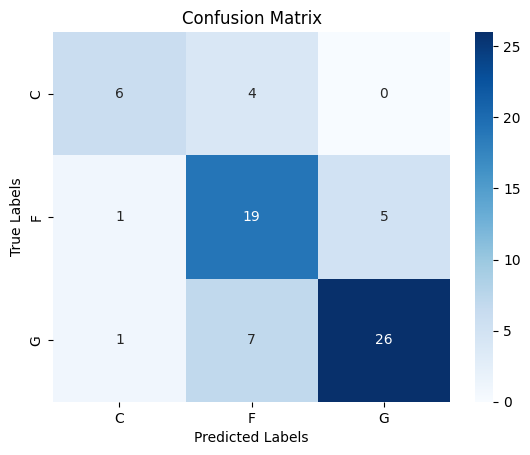

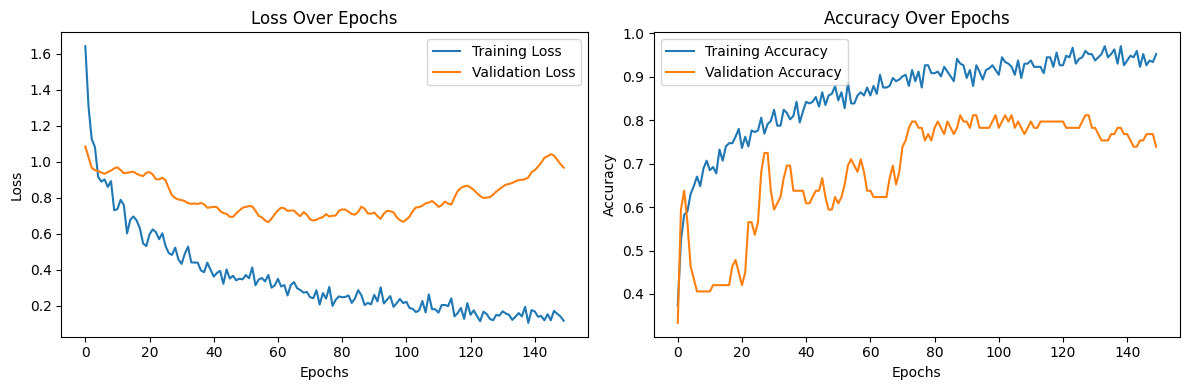

In [80]:
# Assuming 'classification_df' is preloaded
X = classification_df.drop(columns=['PName', 'Team', 'POS', 'POS_grouped', 'POS_encoded'])
y = classification_df['POS_grouped']

# Encode the target variable
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, random_state=42)

# Standardize the data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Reshape the data for CNN (add a channel dimension)
X_train_reshaped = X_train_scaled[..., np.newaxis]
X_test_reshaped = X_test_scaled[..., np.newaxis]

# One-hot encode the target variable
y_train_onehot = to_categorical(y_train)
y_test_onehot = to_categorical(y_test)

# Build the CNN model
model = Sequential([
    Conv1D(64, kernel_size=3, activation='relu', input_shape=(X_train_reshaped.shape[1], 1)),
    BatchNormalization(),
    MaxPooling1D(pool_size=2),
    Dropout(0.3),

    Conv1D(128, kernel_size=3, activation='relu'),
    BatchNormalization(),
    MaxPooling1D(pool_size=2),
    Dropout(0.3),

    Flatten(),
    Dense(128, activation='relu'),
    BatchNormalization(),
    Dropout(0.4),

    Dense(len(np.unique(y_train)), activation='softmax')
])

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Train the model
history = model.fit(X_train_reshaped, y_train_onehot,
                    validation_data=(X_test_reshaped, y_test_onehot),
                    epochs=150,
                    batch_size=64,
                    verbose=1)

# Evaluate the model
eval_results = model.evaluate(X_test_reshaped, y_test_onehot, verbose=0)
print(f"Test Accuracy: {eval_results[1]:.2f}")

# Make predictions
y_pred_probs = model.predict(X_test_reshaped)
y_pred = y_pred_probs.argmax(axis=1)

# Classification Report
print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=label_encoder.classes_))

# Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred)
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.title("Confusion Matrix")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()

# Plot training history
plt.figure(figsize=(12, 4))

# Loss plot
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Loss Over Epochs')

# Accuracy plot
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Accuracy Over Epochs')

plt.tight_layout()
plt.show()

Class-Level Performance

* C (Center): Precision is 0.75, indicating good accuracy in identifying "C" instances. 0.60 recall indicates misses of true instances of "C". The F1-score of 0.67 suggests a moderate balance between precision and recall.

* F (Forward): Strong recall of 0.76 indicates that most "F" instances are correctly identified, though precision is slightly lower at 0.63. The F1-score of 0.69 reflects this trade-off.

* G (Guard): Best-performing class with a high precision of 0.84 and recall of 0.76, resulting in an F1-score of 0.80, indicating reliable classification for "G."

Averages

* Macro Average (F1-score: 0.72): Highlights balanced performance across classes, though slightly lower due to "C" and "F."

* Weighted Average (F1-score: 0.74): Slightly higher due to the larger support for "G," which performs the best among the classes.

### Attempt 2 Conclusion

Overall, we see greatly improved performance, with the model classifying position correctly 75%-80% of the time. Multinomial regression remains the best approach, with an accuracy of ~80%.

# Reflection

As someone passionate about the NBA, this project was very fun. It allowed me to dive deep into a dataset, visualize trends, create clusters representing different player types, and even make predictions about player positions based on various statistics. One of the highlights was breaking down the 10 clusters of players and analyzing the data to understand the key features that distinguished them. It deepended my understanding of certain data science workflows.

Next steps for this project would include expanding this premise to data for other years in the NBA. Not only would more data likely improve the model as a general premise, data dating further back is likely to describe more rigid definitions of what different positions output in a statistical sense. In addition to building a single model trained on all this data, I would also be interested in developing multiple models for different eras, and comparing their performances in order to highlight how positionless basketball has evolved over time.  